![](../../PythonCompendium/storage/banners/15_dynamics.png)

##### <u>Инициализация</u>

In [1]:
from common_func import *
from p_tqdm import p_map

o, num_params, t, w_0, μ, ρ, r_orb, v_orb = init_symbol_params()
w = kf.get_vars("w", 3, numb=False)
q = kf.vec2quat(kf.get_vars(name='q', n=3, numb=False))

Инициализация проекта kiam-formation
Параметры не могут быть загружены! Нет файла: kiamformation/data/config_choose.csv
Матрицы Ф:(6, 6), Q:(3, 3), P:(6, 6), D:(6, 3)
Высота орбиты: 400 км
Период орбиты: 1.54 часов
Плотность атмосферы: 6.404751331738951e-12 кг/м³


##### <u>Матрицы поворота</u>

In [4]:
A = kf.quart2dcm(q)
U = kf.get

kf.my_print(f"Матрица A ИСК->ССК:")
display(A)
print(f"Матрица U ИСК->ОСК:")
display(U)
print(f"Матрица S ОСК->ССК:")
display(S)

Матрица A ИСК->ССК:


Matrix([
[                             -2*q_y**2 - 2*q_z**2 + 1,  2*q_x*q_y + 2*q_z*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1), 2*q_x*q_z - 2*q_y*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1)],
[2*q_x*q_y - 2*q_z*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1),                               -2*q_x**2 - 2*q_z**2 + 1, 2*q_x*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1) + 2*q_y*q_z],
[2*q_x*q_z + 2*q_y*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1), -2*q_x*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1) + 2*q_y*q_z,                              -2*q_x**2 - 2*q_y**2 + 1]])

Матрица U ИСК->ОСК:


NameError: name 'U' is not defined

##### <u>Уравнения движения</u>

In [5]:
U, S, A, R_orb = kf.get_matrices(v=o.v, t=t, obj=o.c, n=0, q=q)
τ = Matrix([1, 0, 0])  # Набегающий поток ОСК
n = S.T @ Matrix([0, 0, 1])  # Нормаль к поверхности ОСК
n.dot(τ)

-(2*q_x*q_z + 2*q_y*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1))*sin(t*ω_0) + (-2*q_x*sqrt(-q_x**2 - q_y**2 - q_z**2 + 1) + 2*q_y*q_z)*cos(t*ω_0)

##### <u>Компоненты производной угловой скорости</u>

In [23]:
M = 3 * μ / R_0**5 * (S @ R_orb).cross(J @ S @ R_orb)
w = Matrix(kf.get_func("w", 3, numb=False, t=t))
dw = Matrix(kf.get_func("dw", 3, numb=False, t=t))

w_diff = J.inv() @ (- (w).cross(J @ w) + M)
w_diff = A.T @ J.inv() @ (- (A @ w).cross(J @ A @ w) + M)

In [ ]:
print(f"Разложение по Тейлору:")
display(w_diff[0].subs([(w[0], w[0]+dw[0])]).diff(dw[0]).expand())

##### <u>Линеаризация уравнений движения</u>

In [3]:
r = get_func("r", 3, numb=False)
v = get_func("v", 3, numb=False)
q = get_func("q", 3, numb=False)
w = get_func("w", 3, numb=False)
q0 = 1 - sqrt(q[0]**2 + q[1]**2 + q[2]**2)

M = 3 * μ / R_0**5 * (S @ R_orb).cross(J @ S @ R_orb)
w_diff = A.T @ J.inv() @ (- (A @ Matrix(w)).cross(J @ A @ Matrix(w)) + M)

state_vector = r + q + v + w
motion_equations = [Eq(r[0].diff(t), v[0]),
                    Eq(r[1].diff(t), v[1]),
                    Eq(r[2].diff(t), v[2]),
                    # Eq(q[0].diff(t), (-w[0]*q[1] - w[1]*q[2] - w[2]*q[3])/2),
                    Eq(q[0].diff(t), (w[0]*q0 + w[1]*q[2] - w[2]*q[1])/2),
                    Eq(q[1].diff(t), (w[1]*q0 + w[2]*q[0] - w[0]*q[2])/2),
                    Eq(q[2].diff(t), (w[2]*q0 + w[0]*q[1] - w[1]*q[0])/2),
                    Eq(v[0].diff(t), -2*w_0 * v[2]),
                    Eq(v[1].diff(t), -w_0**2 * r[1]),
                    Eq(v[2].diff(t), 2*w_0 * v[0] + 3*w_0**2 * r[2]),
                    Eq(w[0].diff(t), (J.inv() @ (- Matrix(w).cross(J @ Matrix(w)) + Matrix(M)))[0]),
                    Eq(w[1].diff(t), (J.inv() @ (- Matrix(w).cross(J @ Matrix(w)) + Matrix(M)))[1]),
                    Eq(w[2].diff(t), (J.inv() @ (- Matrix(w).cross(J @ Matrix(w)) + Matrix(M)))[2])]
motion_derivs = [expr.rhs for expr in motion_equations]

def get_linearized_component(i_exp: int, i_var: int):
    anw = motion_derivs[i_exp].diff(state_vector[i_var])
    sv = state_vector.copy()
    sv.remove(state_vector[i_var])
    for i in sv:
        if anw.diff(i) != 0:
            return 0
    '''for i in state_vector:
        if anw.diff(i) != zero:
            anw -= anw.diff(i) * i'''
    return anw

print(f"Линеаризованная матрица Ф:")
Ф = Matrix(np.zeros((len(motion_equations), len(state_vector))))
for i in range(len(motion_equations)):
    for j in range(len(state_vector)):
        Ф[i, j] = get_linearized_component(i, j)
Ф

Линеаризованная матрица Ф:


Matrix([
[0,       0,        0, 0, 0, 0,     1, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 1,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      1, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0, -2*w_0, 0, 0, 0],
[0, -w_0**2,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0, 3*w_0**2, 0, 0, 0, 2*w_0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0],
[0,       0,        0, 0, 0, 0,     0, 0,      0, 0, 0, 0]])

##### <u>Генерация файла</u> `H_matrix.py` <u>(матрица H)</u> (новое)

In [3]:
# num_params

In [3]:
o = kf.init()
n_vec = 6
GAIN_MODES = o.v.GAIN_MODES.copy()
GAIN_MODES.remove('3 antennas')
GAIN_MODES.remove('ellipsoid')
tf = [True, False]
param_variation = [[angnav, gm_1, gm_2, mulsend, mulsend, rel] for angnav in tf for gm_1 in GAIN_MODES for gm_2 in GAIN_MODES for mulsend in tf for rel in ['cd', 'dd']]

# >>>>>>>>>>>> Гиперпараметры (запихнуть в цикл?) <<<<<<<<<<<<
angnav, gm_1, gm_2, mulsend, mulsend, rel = param_variation[0]
o.f.n = 3
o.c.n = 2
o.c.gain_mode = o.v.GAIN_MODEL_C = '2 antennas'
o.f.gain_mode = o.v.GAIN_MODEL_F = 'isotropic'
o.v.N_ANTENNA_C = 2
o.v.N_ANTENNA_F = 1
o.v.NAVIGATION_ANGLES = True
o.v.MULTI_ANTENNA_SEND = True
o.v.MULTI_ANTENNA_TAKE = True

# >>>>>>>>>>>> Внутри цикла <<<<<<<<<<<<
# Подстановка символьных переменных
t, ω, μ, ρ, r_orb, v_orb = var("t ω_0 μ ρ r_0 v_0")
o.v.ORBIT_RADIUS = r_orb
o.v.V_ORB = v_orb
o.v.W_ORB = ω
o.v.MU = μ

# Те, которые не передаются
o.v.dT = var('dt')

J = [kf.get_vars("J^d", 3, numb=False), kf.get_vars("J^c", 3, numb=False)]
o.f.J = diag(J[0][0], J[0][1], J[0][2])
o.c.J = diag(J[1][0], J[1][1], J[1][2])
o.f.r_orf = [kf.get_vars(name=f'rf^o_{i}', n=3, numb=False) for i in range(o.f.n)]
o.c.r_orf = [kf.get_vars(name=f'rc^o_{i}', n=3, numb=False) for i in range(o.c.n)]
o.f.q = [kf.get_vars(name=f'qf_{i}', n=4, numb=False) for i in range(o.f.n)]
o.c.q = [kf.get_vars(name=f'qc_{i}', n=4, numb=False) for i in range(o.c.n)]
o.f.mass, o.c.mass = var('m_d m_c')
o.f.c_resist, o.c.c_resist = var('C_d C_c')
o.f.size = kf.get_vars(name='s^d', n=2)
o.c.size = kf.get_vars(name='s^c', n=2)
o.p.record = kf.pd.DataFrame()

# >>>>>>>>>>>> Повторная инициализация <<<<<<<<<<<<
# o.init_classes()

# >>>>>>>>>>>> Измерения <<<<<<<<<<<<
kf.measure_antennas_power(c=o.c, f=o.f, v=o.v, noise=0, produce=True, p=o.p, estimated_params=[])
y = o.v.MEASURES_VECTOR
# y

Параметры не могут быть загружены! Нет файла: kiamformation/data/config_choose.csv
Матрицы Ф:(6, 6), Q:(3, 3), P:(6, 6), D:(6, 3)


In [15]:
display(kf.get_gain(v=o.v, obj=o.f, r=np.ones(3), if_take=True))
display(kf.get_gain(v=o.v, obj=o.c, r=np.ones(3), if_take=True))

[1]

[0.7546761650605133, 0.7546761650605133]

##### <u>Режимы вращения</u>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [83]:
Cf = 1
m = 0.03
a = 0.1
b = 0.1

rho =  5.21e-13
S = a*b
M = 5.972e24
G = 6.6743e-11
mu = M * G
v_orb = np.sqrt(mu / 6900e3)
c = Cf * rho * v_orb**2 * S / 6 * m * (a**2 + a*b + b**2)
c

4.514455893826088e-11

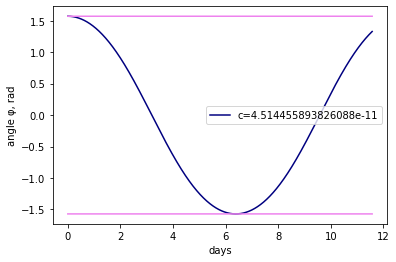

In [91]:
# p = phi
dt = 10.
T = 1e6
days = True

def func(p: float, w: float, c: float, dt: float):
    return p + w * dt, w - dt * c * np.sin(p)

def integrate(c: float, dt: float = 1., T: float = 1000):
    w_list = [0.]
    p_list = [3.1415/2]
    t_list = [0.]
    for i in range(int(round(T / dt))):
        tmp = func(p_list[i], w_list[i], c, dt)
        t_list += [(i+1)*dt]
        p_list += [tmp[0]]
        w_list += [tmp[1]]
    return t_list, p_list

t, p = integrate(c=c, dt=dt, T=T)
t = [i/(3600*24) for i in t] if days else t
plt.plot(t, np.array(p), c='navy', label=f"c={c}")  # /(np.pi/2)
plt.plot(t, [np.pi/2 for _ in range(len(t))], c='violet')
plt.plot(t,[-np.pi/2 for _ in range(len(t))], c='violet')
plt.legend()
plt.xlabel("days" if days else "time t, s")
plt.ylabel("angle φ, rad")
# plt.ylim([-np.pi/2, np.pi/2])
plt.show()

##### Движение со <u>смещённым центром масс</u>

In [1]:
from sympy import *

In [46]:
a, b, ex, ey = var('a b e_x e_y', real=True, constant=True)  # Стороны ЧипСата, отклонения цетра масс
m, f, v = var('m f v', real=True, constant=True)
t = var('t', real=True, constant=False)
n_x = Function("n_x")(t)
n_y = Function("n_y")(t)
n_z = Function("n_z")(t)
w_x = Function("w_x")(t)
w_y = Function("w_y")(t)
w_z = Function("w_z")(t)
x0 = -a + ex
x1 = a + ex
y0 = -b + ey
y1 = b + ey
Ix = m/3 * (x1 - x0) * (y1**3 - y0**3)
Iy = m/3 * (y1 - y0) * (x0**3 - x1**3)
Iz = Ix + Iy  # верно для пластины
eq_n_x = Eq(n_x.diff(t), w_y*n_z - w_z*n_y)
eq_n_y = Eq(n_y.diff(t), w_z*n_x - w_x*n_z)
eq_n_z = Eq(n_z.diff(t), w_x*n_y - w_y*n_x)
eq_x = Eq(f*n_x*v*(x1-x0)*(y1**2-y0**2), Ix * w_x.diff(t) + (Iz - Iy)*w_y*w_z)
eq_y = Eq(f*n_x*v*(y1-y0)*(x0**2-x1**2), Iy * w_y.diff(t) + (Ix - Iz)*w_x*w_z)
eq_z = Eq(0, Iz * w_z.diff(t) + (Iy - Ix)*w_x*w_y)

In [17]:
anw = dsolve({eq_n_x, eq_n_y, eq_n_z, eq_x, eq_y, eq_z})

NotImplementedError: 

##### <u>Свистни</u> когда доделаешь

In [2]:
kf.talk()

Сочувствую.
